# Loadshape pipeline validation

This notebook documents the validation of the `loadshape` pipeline in OpenFIDO (see https://github.com/openfido/loadshape for details on this pipeline). The test case presented here is based on a data set from a utility containing 1 year of AMI data from 2015 for 973 customers. The original dataset has been sanitized to preserve privacy. In addition the subhourly data has been rolled up to hourly data.

The methodology used to create the loadshape data is based on an unsupervised learning algorithm known as k-means clustering which looks for $k$ loadshapes in the data. This method partitions $N$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. Each cluster mean serves as a prototype of the cluster.  This partition produces a data space divided into so-called "Voronoi" cells.  The cluster minimizes the loadshape variances (i.e., the squared Euclidean distances).

The validation performed here applies the loadshape clustering method step by step, visualizing the intermediate results for inspection, and comparing the final result with an alternate t-distributed stochastic neighbor embedded (t-SNE) partitioning method. T-SNE is a dimensionality reduction method that can be used to visualize high-dimensional data as a two or three-dimensional map that does not share any common elements with the k-means method being validated.

# Task 1 - Load the AMI data

The first task performed by the `loadshape` pipeline is to load the AMI data from the sanitized AMI data repository. In this case we are only interested in the timestamps with timezones, the meter ids, and the power values.  All other data in the repository is ignored.

In [1]:
import pandas as pd
import datetime as dt
data = pd.read_csv("ami_sanitized.csv.gz",
    converters = {
        "timestamp" : dt.datetime.fromisoformat,
        "meter_id" : int,
        "tz" : int,
        "power" : float,
    })

In [2]:
data

,meter_id,timestamp,tz,power
0,1,2015-01-01 09:00:00,-8,6.31
1,1,2015-01-01 10:00:00,-8,4.48
2,1,2015-01-01 11:00:00,-8,5.88
3,1,2015-01-01 12:00:00,-8,6.52
4,1,2015-01-01 13:00:00,-8,5.15
...,...,...,...,...
8904094,973,2016-01-02 04:00:00,-8,5.06
8904095,973,2016-01-02 05:00:00,-8,5.61
8904096,973,2016-01-02 06:00:00,-8,5.39
8904097,973,2016-01-02 07:00:00,-8,6.08


The data set contains nearly 9 million records, with meter id, timestamps, timezone, and power measurements.  The timestamps are provided in UTC and the timezone provides the offset of the local time from the UTC timestamp. These will be necessary to determine time-dependent information such as the season, day of week, and local hour of day.

# Task 2 - Identify hour types

The timestamps are then analysed to identify the hour types that used to generate the loadshapes.  The hour type is based on the season (winter=0, spring=1, summer=2, and fall=3) and the day type (weekday=0 and weekend=1). These, along with the 24 hours of the day, result is 192 hour types, which are associated with each meter observation.

In [3]:
hour = (data["timestamp"].apply(lambda x:x.hour-1)+data["tz"]).astype(int).mod(24)
weekend = data["timestamp"].apply(lambda x:(int(x.weekday()/5)))
season = data["timestamp"].apply(lambda x:x.quarter-1)
data["hourtype"] = season*48 + weekend*24 + hour

In [4]:
data

,meter_id,timestamp,tz,power,hourtype
0,1,2015-01-01 09:00:00,-8,6.31,0
1,1,2015-01-01 10:00:00,-8,4.48,1
2,1,2015-01-01 11:00:00,-8,5.88,2
3,1,2015-01-01 12:00:00,-8,6.52,3
4,1,2015-01-01 13:00:00,-8,5.15,4
...,...,...,...,...,...
8904094,973,2016-01-02 04:00:00,-8,5.06,43
8904095,973,2016-01-02 05:00:00,-8,5.61,44
8904096,973,2016-01-02 06:00:00,-8,5.39,45
8904097,973,2016-01-02 07:00:00,-8,6.08,46


# Task 3 - Aggregate hour types

The next task is to calculate the average load for each hour type of each meter. The result is then pivoted to create one column for each hour type and one row for each meter.

In [5]:
groups = data.groupby(["meter_id","hourtype"]).mean().reset_index()
groups = groups.pivot(index="meter_id",columns="hourtype",values="power")
groups.dropna(inplace=True)

In [6]:
groups

hourtype,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
meter_id,,,,,,,,,,,,,,,,,,,,,
1,5.737077,5.319385,4.922769,4.934000,4.465538,4.206308,4.958308,4.715231,4.022615,4.325692,...,5.748462,6.070000,6.210000,7.447308,7.290769,7.204231,7.076154,6.870385,6.311154,5.900769
2,0.549077,0.547538,0.547231,0.548154,0.546923,0.547231,0.545846,0.547538,0.547231,0.549692,...,0.725000,0.725385,0.718462,0.708462,0.698846,0.693462,0.690000,0.686538,0.684231,0.683462
3,2.947692,2.996923,2.886154,2.873846,3.926154,3.335385,3.353846,5.803077,7.833846,8.233846,...,12.276923,12.276923,12.230769,12.015385,11.430769,10.800000,10.476923,6.923077,3.107692,2.538462
4,31.214615,31.007846,32.279231,32.323846,38.841538,39.286923,39.495846,36.140462,38.436462,39.900769,...,48.105385,45.859231,47.810385,49.150769,50.290769,48.923462,45.794615,41.991538,38.596538,36.475000
5,7.696462,7.587692,7.540308,7.479846,7.506923,7.518615,8.356308,9.434615,11.836462,12.259538,...,12.116154,12.112308,12.649615,12.238077,11.801538,11.591538,10.480385,9.303462,8.913462,8.260769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,6.178308,4.785846,4.267385,4.395846,5.758615,10.722462,15.023692,13.951231,10.744615,10.603385,...,12.465000,13.088077,13.675385,15.555000,13.900000,14.266154,13.737692,11.998462,11.312692,8.236154
970,8.640615,7.935385,7.638000,7.110000,7.212154,8.135846,9.932308,8.735077,7.536154,7.648615,...,12.850385,12.022308,12.751923,13.376538,13.823846,14.208077,13.861923,12.586923,11.545769,10.458077
971,10.575231,9.265846,7.694308,7.691077,8.035385,13.257846,13.604154,12.569385,12.651077,11.932769,...,11.926923,11.500385,11.958462,12.915769,13.623077,13.876538,13.421538,14.191923,13.007308,11.916154


We can visualize the average load for each meter by hour type, where hours 0-23 are winter weekdays, hours 24-47 are winter weekends, hours 48-71 are spring weekdays, etc.

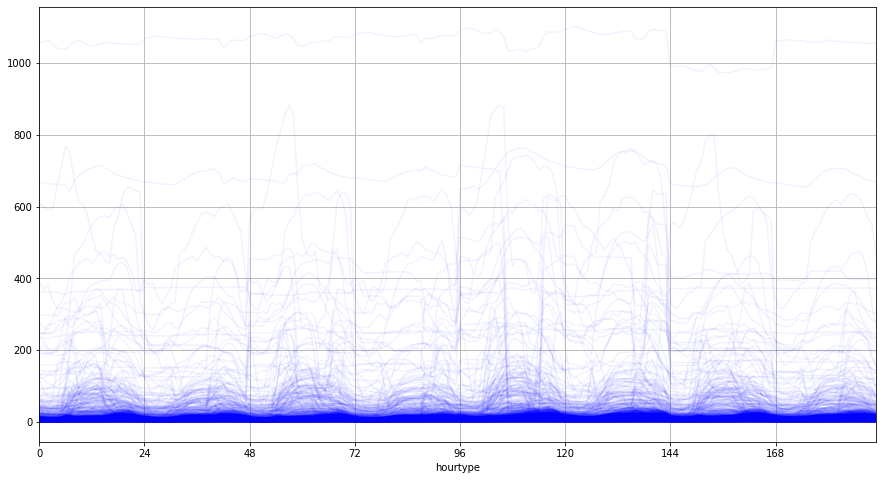

In [7]:
groups.T.plot(figsize=(15,8), legend=False, color='blue', alpha=0.05,grid=True,xlim=[0,191],xticks=range(0,192,24));

# Task 4 - Clustering the meters

The next task is to find the clusters that partition this dataset in loadshapes with minimal Euclidean distances to the cluster centroid.  We use the k-means algorithm to identify the cluster on the normalized hour type profiles. 

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
rescaled = MinMaxScaler().fit_transform(groups.values.copy())
kmeans = KMeans(n_clusters=10)
group_found = kmeans.fit_predict(rescaled)
group_data = pd.Series(group_found, name="loadshape")
groups.set_index(group_data, append=True, inplace=True)

In [9]:
groups

,hourtype,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
meter_id,loadshape,,,,,,,,,,,,,,,,,,,,,
1,0,5.737077,5.319385,4.922769,4.934000,4.465538,4.206308,4.958308,4.715231,4.022615,4.325692,...,5.748462,6.070000,6.210000,7.447308,7.290769,7.204231,7.076154,6.870385,6.311154,5.900769
2,0,0.549077,0.547538,0.547231,0.548154,0.546923,0.547231,0.545846,0.547538,0.547231,0.549692,...,0.725000,0.725385,0.718462,0.708462,0.698846,0.693462,0.690000,0.686538,0.684231,0.683462
3,0,2.947692,2.996923,2.886154,2.873846,3.926154,3.335385,3.353846,5.803077,7.833846,8.233846,...,12.276923,12.276923,12.230769,12.015385,11.430769,10.800000,10.476923,6.923077,3.107692,2.538462
4,8,31.214615,31.007846,32.279231,32.323846,38.841538,39.286923,39.495846,36.140462,38.436462,39.900769,...,48.105385,45.859231,47.810385,49.150769,50.290769,48.923462,45.794615,41.991538,38.596538,36.475000
5,0,7.696462,7.587692,7.540308,7.479846,7.506923,7.518615,8.356308,9.434615,11.836462,12.259538,...,12.116154,12.112308,12.649615,12.238077,11.801538,11.591538,10.480385,9.303462,8.913462,8.260769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,0,6.178308,4.785846,4.267385,4.395846,5.758615,10.722462,15.023692,13.951231,10.744615,10.603385,...,12.465000,13.088077,13.675385,15.555000,13.900000,14.266154,13.737692,11.998462,11.312692,8.236154
970,0,8.640615,7.935385,7.638000,7.110000,7.212154,8.135846,9.932308,8.735077,7.536154,7.648615,...,12.850385,12.022308,12.751923,13.376538,13.823846,14.208077,13.861923,12.586923,11.545769,10.458077
971,0,10.575231,9.265846,7.694308,7.691077,8.035385,13.257846,13.604154,12.569385,12.651077,11.932769,...,11.926923,11.500385,11.958462,12.915769,13.623077,13.876538,13.421538,14.191923,13.007308,11.916154


A histogram of the loadshapes found shows that only a few loadshapes are common and the remaining ones are idiosyncratic.

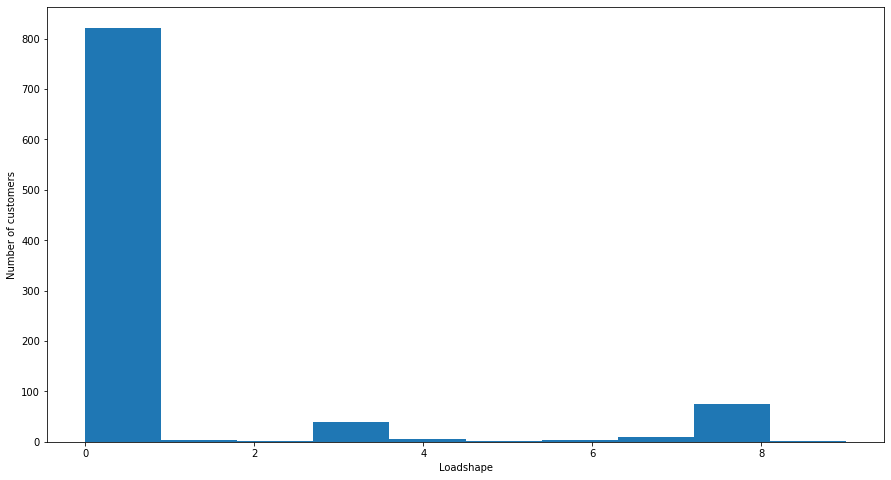

In [10]:
ax = groups.reset_index()["loadshape"].hist(figsize=(15,8),grid=False,bins=10)
ax.set_xlabel("Loadshape")
ax.set_ylabel("Number of customers");
#groups.reset_index().drop(range(192),axis=1).groupby("loadshape").count().plot.pie(y="meter_id",figsize=(8,8))

The loadshape data is obtained by aggregating the median load and relabeling the columns to improve readability.

In [11]:
loadshapes = groups.groupby("loadshape").median()
seasons = ["win","spr","sum","fal"]
weekdays = ["wd","we"]
loadshapes.columns = [f"{seasons[season]}_{weekdays[weekend]}_{hour}h" for season in range(4) for weekend in range(2) for hour in range(24)]

In [12]:
loadshapes

,win_wd_0h,win_wd_1h,win_wd_2h,win_wd_3h,win_wd_4h,win_wd_5h,win_wd_6h,win_wd_7h,win_wd_8h,win_wd_9h,...,fal_we_14h,fal_we_15h,fal_we_16h,fal_we_17h,fal_we_18h,fal_we_19h,fal_we_20h,fal_we_21h,fal_we_22h,fal_we_23h
loadshape,,,,,,,,,,,,,,,,,,,,,
0,6.576692,5.846154,5.486308,5.375769,5.552077,6.026231,7.010692,7.334538,6.864231,6.692538,...,9.592885,9.598269,10.084423,11.358077,11.755385,11.936538,11.767308,11.118462,10.209231,9.070577
1,203.643000,206.898692,198.155077,196.692692,206.298538,231.360462,237.961385,244.946000,247.941615,249.747538,...,259.931538,262.747500,260.035769,263.209423,256.302308,256.756154,249.106731,243.564231,230.973654,226.385577
2,472.073538,465.520615,461.137846,475.285846,489.071077,489.785538,496.389231,486.953538,570.507692,582.705231,...,662.333077,654.971538,664.474615,665.736923,661.970769,655.086923,640.670769,623.956154,610.220769,563.700000
3,43.684308,39.243077,38.655769,39.161154,40.817231,46.855385,52.382923,58.028923,66.798077,77.784615,...,83.004808,84.138462,88.561538,87.779423,83.588077,81.250962,71.923077,66.009615,58.722115,52.964615
4,274.841923,272.738154,284.574769,285.564000,286.879077,300.092385,301.117385,296.603385,301.195846,313.868231,...,379.055385,376.679231,377.173846,372.039231,366.350769,358.760000,349.404615,342.354615,316.572308,290.537115
5,1056.641538,1059.452308,1061.169231,1055.173846,1040.995385,1038.807692,1038.627692,1049.358462,1058.316923,1062.373846,...,1060.130769,1058.434615,1058.123077,1056.980769,1056.738462,1056.253846,1055.526923,1053.726923,1054.280769,1056.253846
6,86.664000,86.680615,85.532308,82.715077,82.702154,85.327385,88.770462,98.604923,114.528000,115.753846,...,145.680000,156.807692,145.670769,145.749231,145.763077,145.920000,146.044615,145.984615,143.690769,145.924615
7,120.983231,110.322000,113.033077,115.341692,128.446769,134.732923,142.757538,145.311692,153.655538,139.838769,...,139.555769,154.171346,175.250000,192.110769,184.707115,178.796346,176.116538,165.885769,147.702692,136.882308
8,21.678154,20.932000,20.359385,19.903385,19.903385,21.608000,25.961077,30.104615,32.461385,36.247385,...,34.046154,35.515385,40.507692,37.905000,37.964615,35.778846,33.790769,31.646154,28.627308,24.675769


The final results are plotted with the original data to visualize how the loadshapes are representative of each cluster.

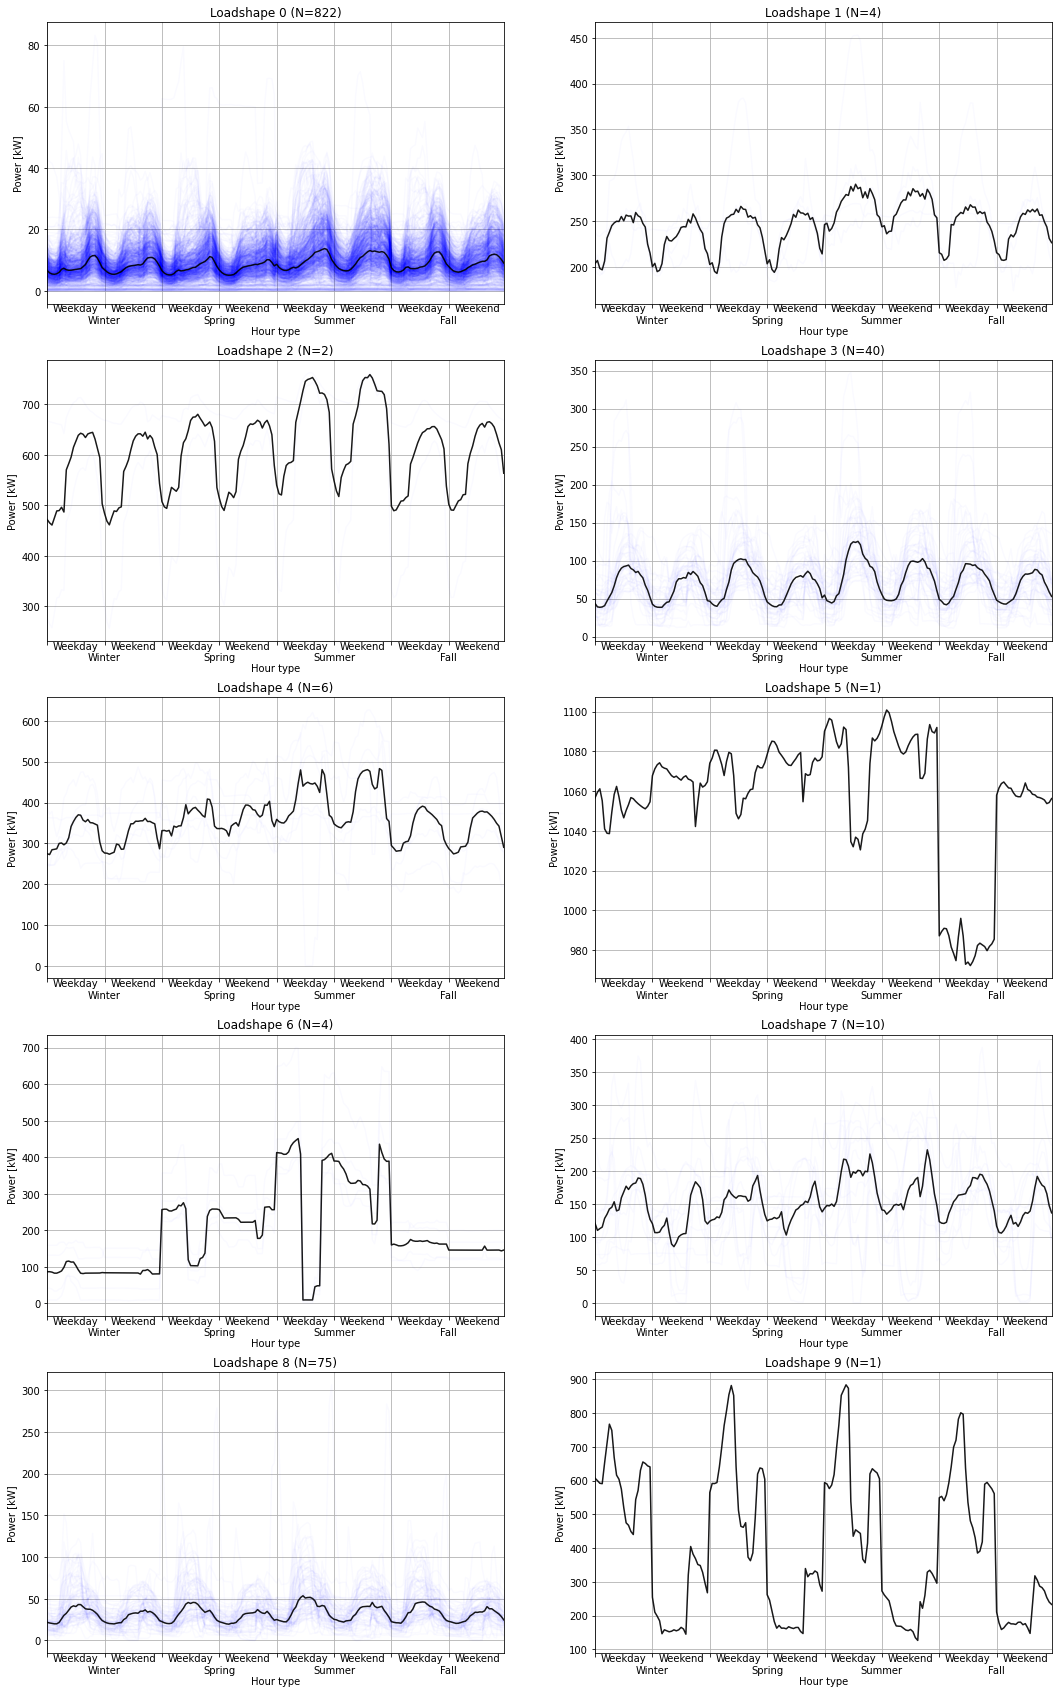

In [13]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(int(loadshapes.shape[0]/2),2, figsize=(18,3*loadshapes.shape[0]))
for group in groups.index.get_level_values(level=1).unique():
    subset = groups.xs(group, level=1)
    ax = plt.subplot(int(loadshapes.shape[0]/2),2,group+1)
    plt.plot(subset.T,alpha=0.02,ls='-',color="blue")
    plt.plot(subset.median(), alpha=0.9, ls='-',color="black")
    ax.set_title(f"Loadshape {group} (N={len(subset)})")
    ax.set_ylabel('Power [kW]')
    ax.set_xlabel('\nHour type')
    ax.grid()
    y0 = ax.get_ylim()[0]
    for s in range(4):
        for w in range(2):
            label = plt.text(s*48+w*24+12,y0,["Weekday","Weekend"][w],axes=ax)
            label.set_ha("center")
            label.set_va("top")
        label = plt.text(s*48+24,y0,["\nWinter","\nSpring","\nSummer","\nFall"][s],axes=ax)    
        label.set_ha("center")
        label.set_va("top")
    plt.xticks(range(0,192,24),[],axes=ax)
    plt.xlim([0,191])            

# Task 5 - Generate the loadshape  weights

The loadshape weights can be generated by computing the total energy in each loadshape meter group.

loadshape,0,1,2,3,4,5,6,7,8,9
energy,0.308,0.051,0.068,0.131,0.1,0.082,0.032,0.069,0.122,0.038


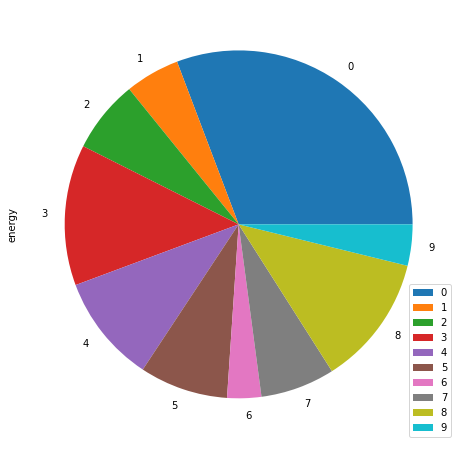

In [14]:
loadshapes = groups.drop(range(192),axis=1)
total = data.drop("tz",axis=1).set_index(["meter_id","hourtype"]).join(loadshapes).groupby("loadshape").sum()
total.columns = ["energy"]
(total/total.sum()).plot.pie(y="energy",figsize=(8,8),normalize=True);
(total/total.sum()).round(3).T

# Task 7 -Validation

The final result is validated using a t-distributed stochastic neighbor embedding algorithim to reduce the dimensionality of the original data set to two dimensions. The color of each point in the map corresponds to each loadshape.  The grouping of similar loadshapes shows how the cluster methods produce similar results.

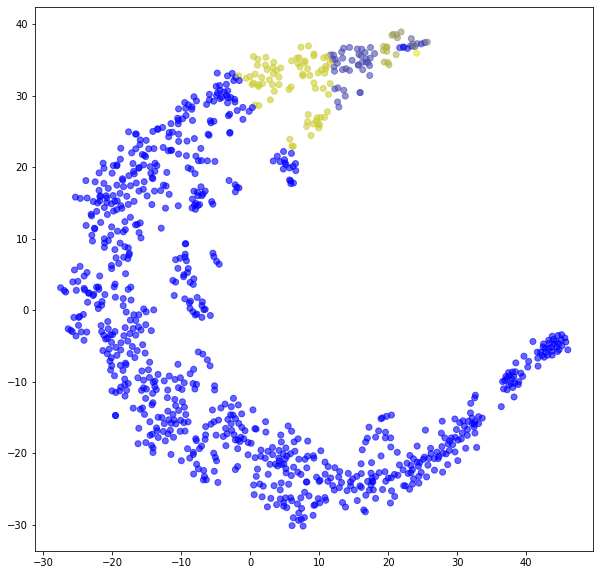

In [15]:
from sklearn.manifold import TSNE
import matplotlib.colors
import numpy as np

tsne = TSNE()
results_tsne = tsne.fit_transform(rescaled)

color_list = list(zip(np.arange(0,1,0.1),np.arange(0,1,0.1),np.arange(1,0,-0.1)))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(groups.index.get_level_values(level=1).unique(), color_list)

plt.figure(figsize=(10,10))
plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=groups.index.get_level_values(level=1),
    cmap=cmap, 
    alpha=0.6, 
    );